In [1]:
import os
from os.path import join
import yaml
import pickle
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
mpl.style.use('../paper.mcstyle')

import seaborn as sns
import pandas as pd

import numpy as np
from scipy.stats import norm
import torch

import ili
from ili.dataloaders import StaticNumpyLoader, SBISimulator
from ili.validation.runner import ValidationRunner 
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior


from CASBI.generator.fff.fff_model import FreeFormFlow
from CASBI.utils.create_dataframe import rescale


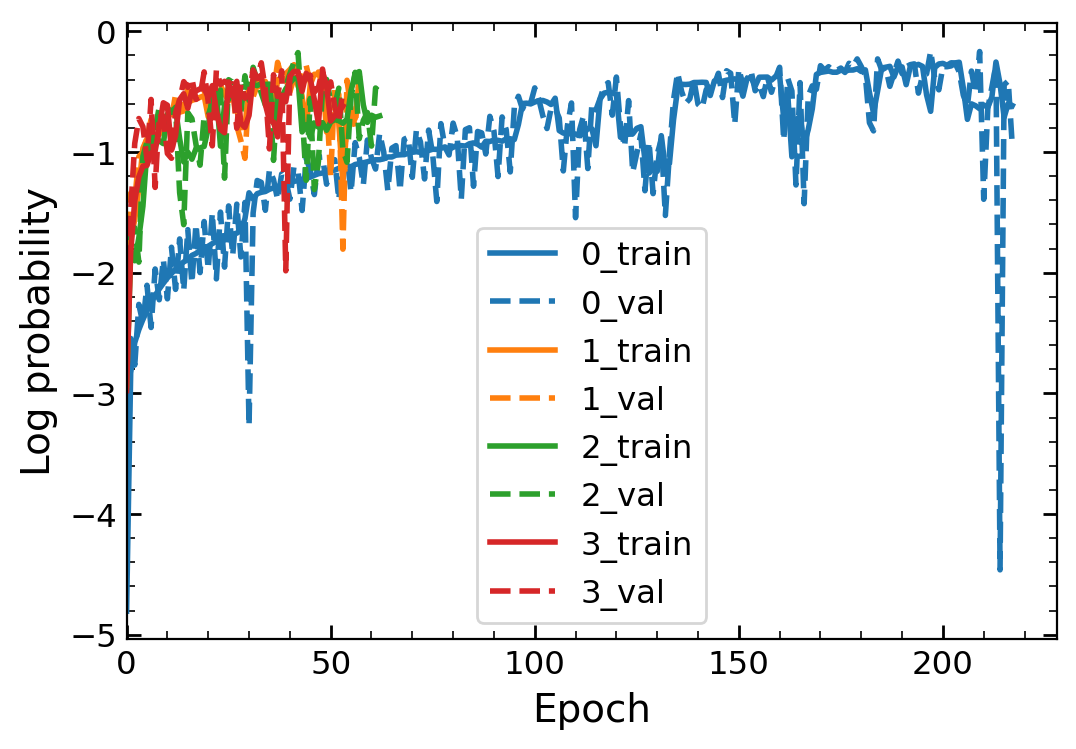

In [2]:
# Open the JSON file
with open('toy_NPE_summary.json', 'r') as f:
    # Load the data from the file
    summaries = json.load(f)
    
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [3]:
path = '../../../../../../data/vgiusepp/'
labels = ['N subhalos']
samples = {}
m = 'NPE'
with open(join('./', 'toy_NPE_posterior.pkl'), 'rb') as f:
    samples[m] = pickle.load(f)
posterior_samples = samples['NPE'].sample((5_000,), x=torch.from_numpy(np.load(path+'x_0.npy')).to('cuda'))

Drawing 1280 posterior samples:   0%|          | 0/1280 [00:00<?, ?it/s]

Drawing 1167 posterior samples:   0%|          | 0/1167 [00:00<?, ?it/s]

Drawing 1291 posterior samples:   0%|          | 0/1291 [00:00<?, ?it/s]

Drawing 1262 posterior samples:   0%|          | 0/1262 [00:00<?, ?it/s]

Drawing 1359 posterior samples:   0%|          | 0/1359 [00:00<?, ?it/s]

Drawing 1180 posterior samples:   0%|          | 0/1180 [00:00<?, ?it/s]

Drawing 1283 posterior samples:   0%|          | 0/1283 [00:00<?, ?it/s]

Drawing 1178 posterior samples:   0%|          | 0/1178 [00:00<?, ?it/s]

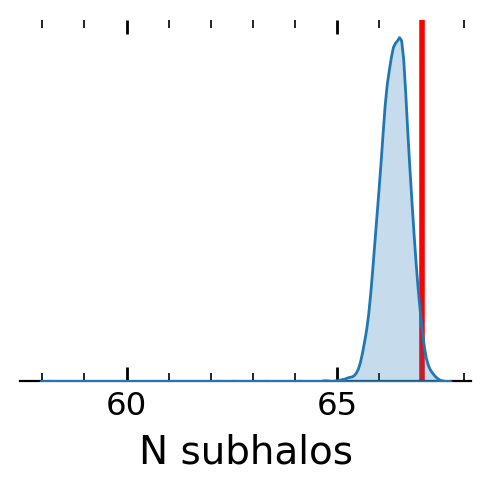

In [4]:
metric = PlotSinglePosterior(
    num_samples=5_000, sample_method='direct', 
    labels = labels,
    out_dir=None
)
fig = metric(
    posterior=samples[m],
    x_obs = torch.from_numpy(np.load(path+'x_0.npy')), theta_fid=torch.from_numpy(np.load(path+'N_subhalos_0.npy')),
)
fig.savefig('corner_Nsubhalos.png')

100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


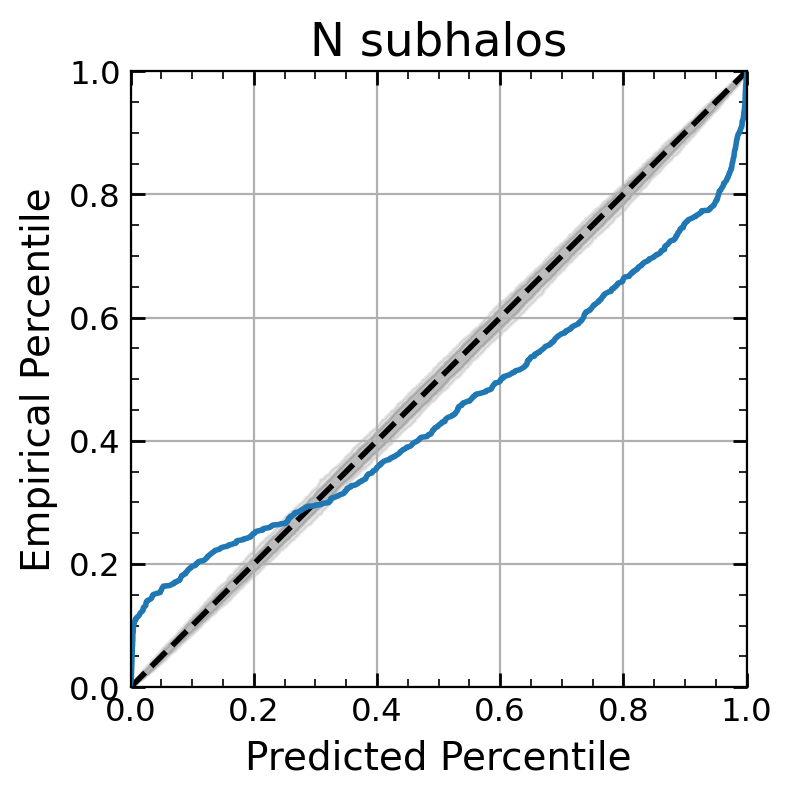

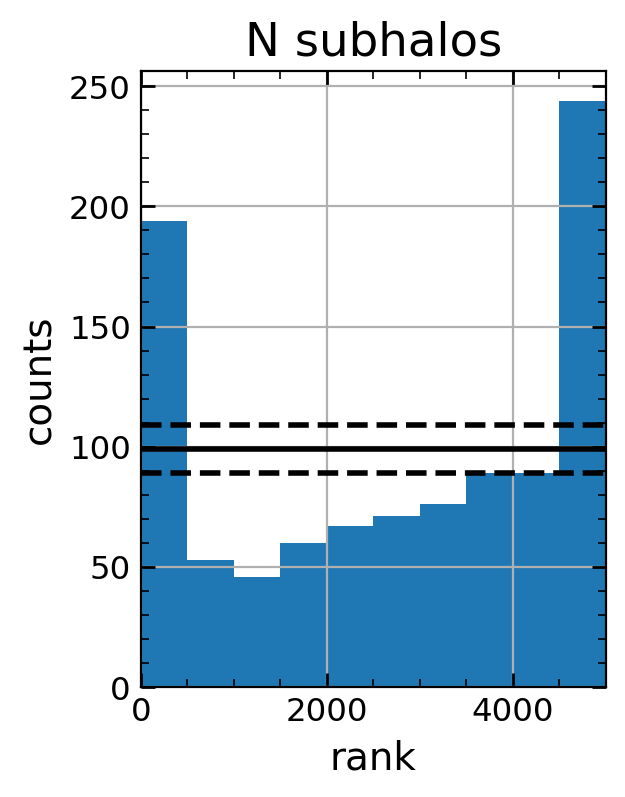

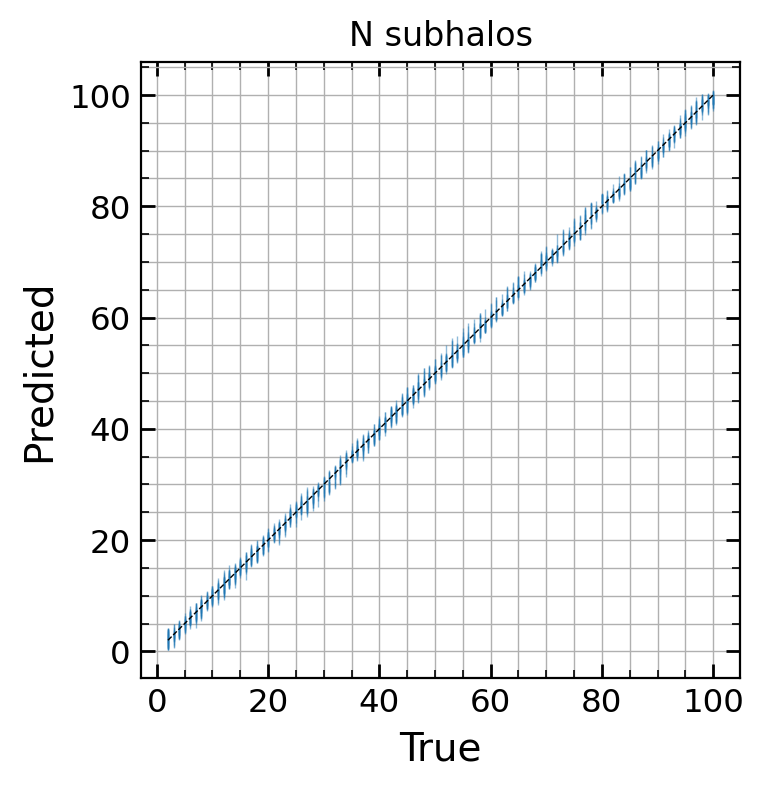

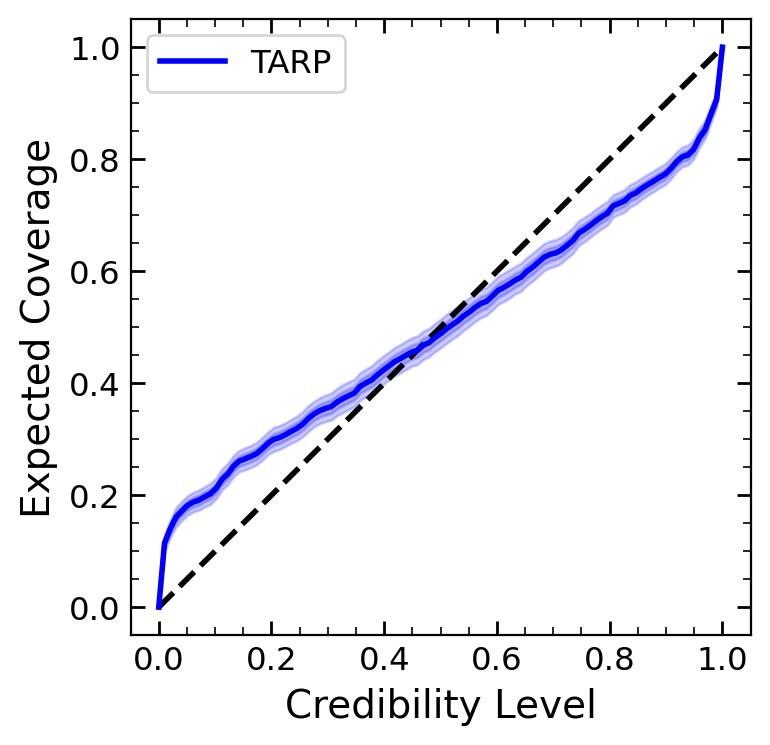

In [5]:
metric = PosteriorCoverage(
    num_samples=5000, sample_method='direct',
    labels=labels, plot_list = ["coverage", "histogram", "predictions", "tarp"]
)
fig = metric(
    posterior=samples[m],
    x=torch.from_numpy(np.load(path+'x_test.npy')), theta=torch.from_numpy(np.load(path+'N_subhalos_test.npy'))
)
fig[3].savefig('coverage_Nsubhalos.png')

In [6]:
theta_test = torch.from_numpy(np.load(path+'N_subhalos_test.npy')).to('cuda')
x_test = torch.from_numpy(np.load(path+'x_test.npy')).to('cuda')
posterior_mean = torch.zeros_like(theta_test, dtype=torch.float64)
posterior_std = torch.zeros_like(theta_test, dtype=torch.float64)
for i, x_0 in enumerate(x_test):
    test_sample = samples['NPE'].sample((10_000,), x=x_0, show_progress_bars=False)
    posterior_mean[i] = test_sample.mean(axis=0)
    posterior_std[i] = test_sample.std(axis=0)

In [7]:
mre = ((theta_test - posterior_mean).abs() / theta_test.abs()).mean(axis=0)
r2 = 1 - ((theta_test - posterior_mean)**2).sum(axis=0) / ((theta_test - theta_test.mean(axis=0, dtype=float))**2).sum(axis=0)
mse = ((theta_test - posterior_mean)**2).mean(axis=0, dtype=float)
chi2 = ((theta_test - posterior_mean)**2 / posterior_std**2).mean(axis=0, dtype=float)
print('MRE:', mre)
print('MSE:', mse)
print('R2:', r2)
print('chi2:', chi2)

MRE: tensor([0.0282], device='cuda:0', dtype=torch.float64)
MSE: tensor([2.4242], device='cuda:0', dtype=torch.float64)
R2: tensor([0.9970], device='cuda:0', dtype=torch.float64)
chi2: tensor([1.4008], device='cuda:0', dtype=torch.float64)
